In [1]:
import os
import sys

os.chdir('..')

In [2]:
import torch
import numpy as np
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem.Descriptors import qed, MolWt
from rdkit.Chem.Draw import MolsToGridImage

/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from src.tacogfn.tasks import pharmaco_frag

In [4]:
model_state = torch.load('logs/2024_01_11_run_pharmaco_frag_beta_qed/model_state.pt')

In [5]:
trail = pharmaco_frag.PharmacophoreTrainer(model_state['cfg'])

loaded 12877 ids for train
loaded 73 ids for test


Hyperparameters:

log_dir: ./logs/2024_01_11_run_pharmaco_frag_beta_qed
device: cuda
split_file: dataset/split_by_name.pt
pharmacophore_db_path: misc/pharmacophores.lmdb
affinity_predictor_path: logs/debug_docking_score_prediction_beta/model_state_23.pt
seed: 0
validate_every: 1000
checkpoint_every: null
print_every: 100
start_at_step: 0
num_final_gen_steps: null
num_training_steps: 10000
num_workers: 0
hostname: DESKTOP-2DNJF9F
pickle_mp_messages: false
git_hash: 6ae029a
overwrite_existing_exp: true
algo:
  method: TB
  global_batch_size: 64
  max_len: 128
  max_nodes: 9
  max_edges: 128
  illegal_action_logreward: -75.0
  offline_ratio: 0.0
  valid_offline_ratio: 0.0
  train_random_action_prob: 0.01
  valid_random_action_prob: 0.0
  valid_sample_cond_info: true
  sampling_tau: 0.99
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameter

In [6]:
trail.model.load_state_dict(model_state['models_state_dict'][0])
trail.model.eval()

PharmacophoreConditionalGraphTransformerGFN(
  (transf): PharmacophoreConditionalGraphTransformer(
    (pharmacophore_encoder): GVP_embedding(
      (W_s): Embedding(10, 10)
      (W_v): Sequential(
        (0): LayerNorm(
          (scalar_norm): LayerNorm((34,), eps=1e-05, elementwise_affine=True)
        )
        (1): GVP(
          (wh): Linear(in_features=1, out_features=16, bias=False)
          (ws): Linear(in_features=50, out_features=64, bias=True)
          (wv): Linear(in_features=16, out_features=16, bias=False)
        )
      )
      (W_e): Sequential(
        (0): LayerNorm(
          (scalar_norm): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
        )
        (1): GVP(
          (wh): Linear(in_features=1, out_features=1, bias=False)
          (ws): Linear(in_features=25, out_features=32, bias=True)
          (wv): Linear(in_features=1, out_features=1, bias=False)
        )
      )
      (layers): ModuleList(
        (0): GVPConvLayer(
          (conv): GVPCon

In [7]:
test_idxs = trail.pharmaco_db.get_partition_idxs('test')

In [8]:
mols = trail.sample_molecules(
    test_idxs,
)

/home/tsa87/refactor-tacogfn/src/tacogfn/utils/conditioning.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(conditional), cfg.num_thermometer_dim, 0, self.upper_bound


In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
preds = trail.task.predict_docking_score(
    mols,
    torch.tensor(test_idxs)
)

In [11]:
qeds = [qed(mol) for mol in mols]
np.mean(qeds), np.std(qeds)

(0.6840283871615154, 0.128321450584752)

In [12]:
# magic reload for jupyter
%load_ext autoreload
%autoreload 2

In [13]:
from src.tacogfn.utils import sascore
from src.tacogfn.eval import docking
from src.tacogfn.utils import molecules

In [14]:
sa_scores = [(10 - sascore.calculateScore(mol)) / 9 for mol in mols]
np.mean(sa_scores), np.std(sa_scores)

(0.6779510292853684, 0.07795130569941346)

In [15]:
pdb_to_ligand = torch.load('dataset/crossdock_pocket_to_native_ligand.pt')

In [16]:
pdb_to_centroid = {}

for pdb_path, ligand_path in tqdm(pdb_to_ligand.items()):
    pdb_id = pdb_path.split('/')[-1].split('_rec')[0]
    centroid = molecules.get_centroid_from_sdf(ligand_path.replace('../', '').replace('.pdb', '.sdf'))
    pdb_to_centroid[pdb_id] = centroid

  0%|          | 1/19899 [00:00<1:45:07,  3.15it/s]

100%|██████████| 19899/19899 [00:04<00:00, 4141.66it/s]


In [17]:
scores = []

for i, idx in tqdm(enumerate(test_idxs)):
    pdb_id = trail.pharmaco_db.idx_to_id[idx]
    pocket_path = f'dataset/crossdock/{pdb_id}_rec.pdb'
    smi = Chem.MolToSmiles(mols[i])

    score = docking.compute_docking_score_from_smiles(
        pocket_path,
        smi,
        keep_temp_folder=False,
        center=pdb_to_centroid[pdb_id],
    )
    
    print(score)
    
    scores.append(score)

0it [00:00, ?it/s]

adding gasteiger charges to peptide


1it [00:06,  6.71s/it]

-5.7
adding gasteiger charges to peptide


2it [00:12,  6.34s/it]

-7.4
adding gasteiger charges to peptide


3it [00:17,  5.51s/it]

-6.7
adding gasteiger charges to peptide


4it [00:23,  5.67s/it]

-8.3
adding gasteiger charges to peptide


5it [00:27,  5.31s/it]

-9.1
WARNING! 3b6h_A_rec has 10  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


6it [00:33,  5.38s/it]

-8.0
WARNING! 4azf_A_rec has 6  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


7it [00:36,  4.70s/it]

-8.7
WARNING! 4iiy_A_rec has 48  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


8it [00:41,  4.67s/it]

-7.9
adding gasteiger charges to peptide


9it [00:45,  4.66s/it]

-8.3
adding gasteiger charges to peptide


10it [00:52,  5.16s/it]

-7.2
WARNING! 5mma_A_rec has 17  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


11it [00:56,  4.97s/it]

-8.5
WARNING! 5liu_X_rec has 37  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


12it [01:00,  4.72s/it]

-10.4
WARNING! 5mgl_A_rec has 5  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


13it [01:04,  4.33s/it]

-6.1
adding gasteiger charges to peptide


14it [01:10,  4.87s/it]

-8.8
adding gasteiger charges to peptide


15it [01:16,  5.11s/it]

-6.2
adding gasteiger charges to peptide


16it [01:22,  5.48s/it]

-10.1
adding gasteiger charges to peptide


17it [01:26,  5.17s/it]

-8.6
adding gasteiger charges to peptide


18it [01:32,  5.24s/it]

-11.4
adding gasteiger charges to peptide


19it [01:36,  4.91s/it]

-8.6
WARNING! 3nfb_A_rec has 63  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


20it [01:41,  5.06s/it]

-6.9
adding gasteiger charges to peptide


21it [01:46,  4.84s/it]

-6.7
adding gasteiger charges to peptide


22it [01:49,  4.52s/it]

-6.5
WARNING! 4bel_A_rec has 50  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


23it [01:53,  4.34s/it]

-7.1
WARNING! 4rn0_B_rec has 81  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


24it [01:58,  4.29s/it]

-6.0
adding gasteiger charges to peptide


25it [02:02,  4.27s/it]

-8.7
WARNING! 5d7n_D_rec has 23  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


26it [02:06,  4.37s/it]

-9.6
adding gasteiger charges to peptide


27it [02:11,  4.41s/it]

-6.0
WARNING! 4u5s_A_rec has 10  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


28it [02:15,  4.39s/it]

-5.6
WARNING! 4d7o_A_rec has 21  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


29it [02:21,  4.83s/it]

-9.3
WARNING! 4rv4_A_rec has 17  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


30it [02:24,  4.39s/it]

-5.8
adding gasteiger charges to peptide


31it [02:28,  4.22s/it]

-5.9
adding gasteiger charges to peptide


32it [02:34,  4.57s/it]

-7.3
adding gasteiger charges to peptide


33it [02:40,  5.22s/it]

-8.6
WARNING! 3tym_A_rec has 12  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


34it [02:47,  5.62s/it]

-8.7
adding gasteiger charges to peptide


35it [02:52,  5.50s/it]

-11.1
adding gasteiger charges to peptide


36it [02:57,  5.17s/it]

-6.3
adding gasteiger charges to peptide


37it [03:03,  5.49s/it]

-8.5
adding gasteiger charges to peptide


38it [03:08,  5.36s/it]

-7.1
WARNING! 4ja8_B_rec has 45  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


39it [03:12,  5.11s/it]

-5.7
adding gasteiger charges to peptide


40it [03:18,  5.24s/it]

-7.0
adding gasteiger charges to peptide


41it [03:25,  5.69s/it]

-6.3
adding gasteiger charges to peptide


42it [03:30,  5.70s/it]

-8.6
WARNING! 5l1v_A_rec has 20  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


43it [03:39,  6.45s/it]

-8.6
adding gasteiger charges to peptide


44it [03:44,  6.11s/it]

-9.4
adding gasteiger charges to peptide


45it [03:49,  5.74s/it]

-7.5
WARNING! 3chc_B_rec has 13  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


46it [03:53,  5.22s/it]

-9.0
adding gasteiger charges to peptide


47it [03:56,  4.75s/it]

-6.0
WARNING! 5bur_A_rec has 6  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


48it [04:02,  4.90s/it]

-7.9
adding gasteiger charges to peptide


49it [04:07,  4.94s/it]

-10.4
adding gasteiger charges to peptide


50it [04:11,  4.67s/it]

-6.8
WARNING! 5aeh_A_rec has 6  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


51it [04:16,  4.72s/it]

-8.4
WARNING! 2z3h_A_rec has 136  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


52it [04:20,  4.48s/it]

-7.5
adding gasteiger charges to peptide


53it [04:24,  4.60s/it]

-10.1
WARNING! 4rlu_A_rec has 17  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


54it [04:29,  4.63s/it]

-6.6
WARNING! 2azy_A_rec has 25  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


55it [04:33,  4.50s/it]

-9.4
adding gasteiger charges to peptide


56it [04:39,  4.86s/it]

-9.8
adding gasteiger charges to peptide


57it [04:43,  4.75s/it]

-9.8
adding gasteiger charges to peptide


58it [04:48,  4.68s/it]

-7.7
WARNING! 4p6p_A_rec has 34  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


59it [04:55,  5.28s/it]

-5.6
adding gasteiger charges to peptide


60it [04:59,  5.05s/it]

-8.8
adding gasteiger charges to peptide


61it [05:03,  4.73s/it]

-9.1
adding gasteiger charges to peptide


62it [05:08,  4.69s/it]

-8.7
WARNING! 2v3r_A_rec has 180  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


63it [05:12,  4.62s/it]

-9.1
adding gasteiger charges to peptide


64it [05:16,  4.43s/it]

-6.8
WARNING! 2jjg_A_rec has 8  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


65it [05:22,  4.71s/it]

-6.5
WARNING! 2hcj_B_rec has 65  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


66it [05:25,  4.31s/it]

-7.8
adding gasteiger charges to peptide


67it [05:31,  4.97s/it]

-6.6
WARNING! 4m7t_A_rec has 7  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


68it [05:36,  4.84s/it]

-7.9
WARNING! 4pxz_A_rec has 7  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


69it [05:42,  5.07s/it]

-8.8
adding gasteiger charges to peptide


70it [05:46,  4.72s/it]

-6.3
WARNING! 3daf_A_rec has 23  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


71it [05:50,  4.60s/it]

-7.8
WARNING! 4f1m_A_rec has 5  atoms with alternate locations named ['A']!

WARNING! using alternate location A
adding gasteiger charges to peptide


72it [05:54,  4.61s/it]

-8.6
adding gasteiger charges to peptide


73it [06:00,  4.94s/it]

-6.4


In [18]:
np.mean(scores), np.std(scores)

(-7.8767123287671215, 1.4271842714388787)

In [21]:
len(preds)

64

Text(0, 0.5, 'Actual docking score')

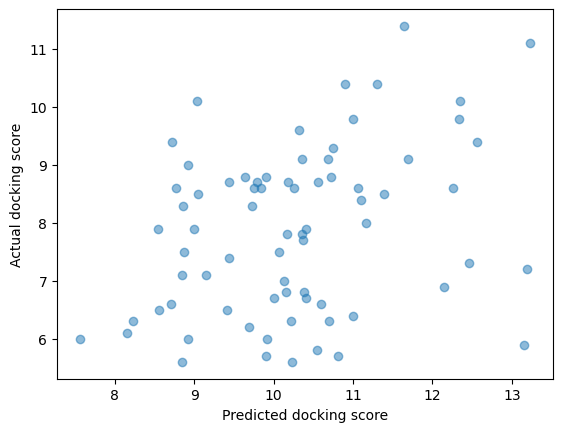

In [35]:
# # scatter plot
import matplotlib.pyplot as plt

plt.scatter(
    preds*-1,
    [s*-1 for s in scores],
    alpha=0.5
)

plt.xlabel('Predicted docking score')
plt.ylabel('Actual docking score')

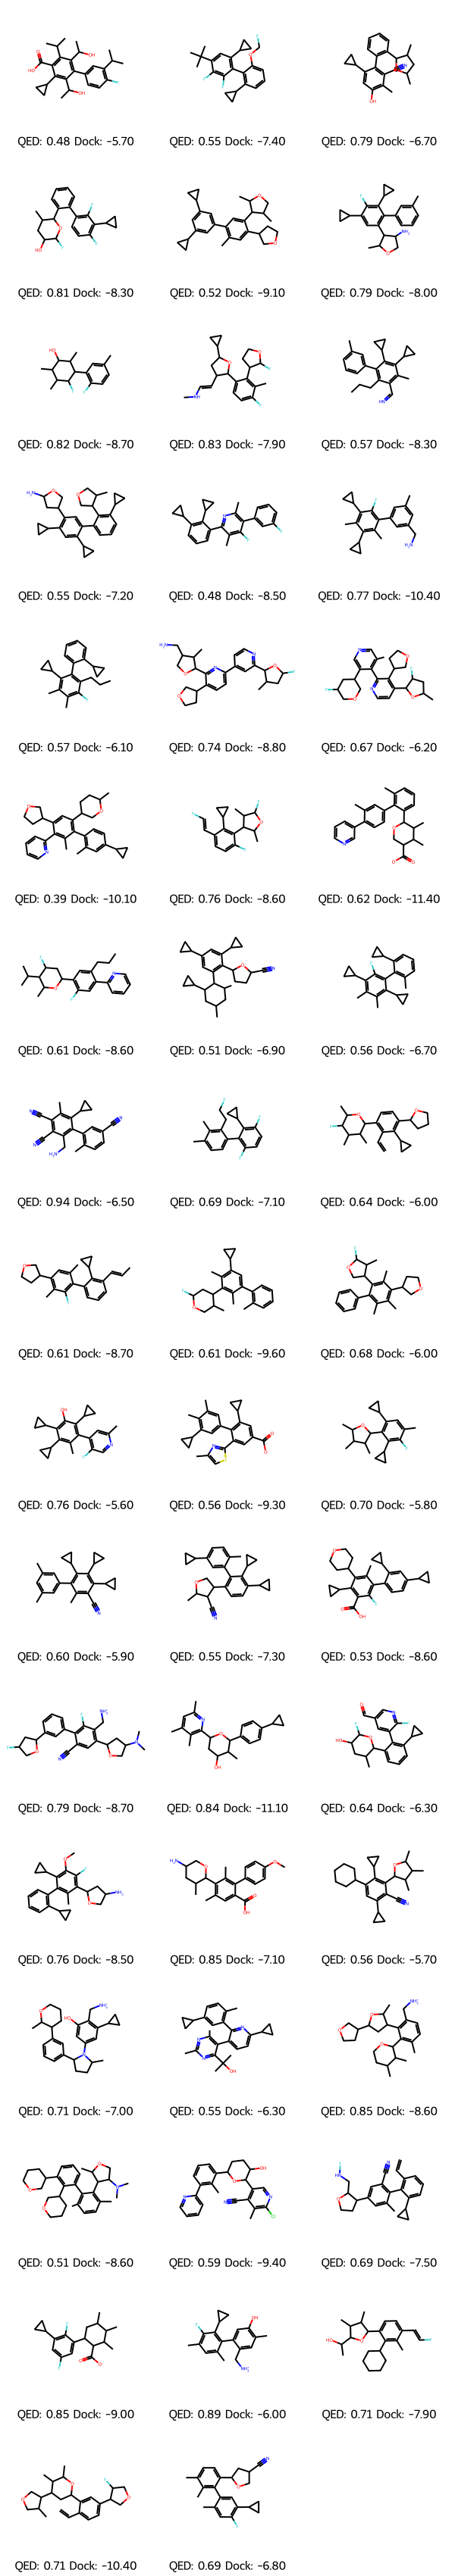

In [37]:
MolsToGridImage(mols, legends=[f'QED: {qed(mol):.2f} Dock: {scores[i]:.2f}' for i, mol in enumerate(mols)])